In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import pinv
from scipy.stats import multivariate_normal
from scipy.stats import gamma
from scipy.stats import invgauss
from scipy.stats import norm
from scipy.stats import reciprocal
np.set_printoptions(precision=3)
np.random.seed(0)

In [2]:
df = pd.read_csv('longley.txt', sep=',')
df = df.drop(columns = ['Year'])
D = df.rename(columns = {'Year.1':'Year'})
D

,GNP.deflator,GNP,Unemployed,Armed.Forces,Population,Year,Employed
0,83.0,234.289,235.6,159.0,107.608,1947,60.323
1,88.5,259.426,232.5,145.6,108.632,1948,61.122
2,88.2,258.054,368.2,161.6,109.773,1949,60.171
3,89.5,284.599,335.1,165.0,110.929,1950,61.187
4,96.2,328.975,209.9,309.9,112.075,1951,63.221
5,98.1,346.999,193.2,359.4,113.270,1952,63.639
6,99.0,365.385,187.0,354.7,115.094,1953,64.989
7,100.0,363.112,357.8,335.0,116.219,1954,63.761
8,101.2,397.469,290.4,304.8,117.388,1955,66.019
9,104.6,419.180,282.2,285.7,118.734,1956,67.857


In [3]:
X = D.values[:,:6]
X_scaler = StandardScaler()
X = X_scaler.fit_transform(X)

In [4]:
y = D.values[:,6]
y_bar = np.mean(y)
y = y - y_bar

In [5]:
n = np.size(X,0)
p = np.size(X,1)

In [6]:
beta_0 = pinv(X.transpose().dot(X) + np.identity(p)).dot(X.transpose().dot(y))

In [7]:
r = y - X.dot(beta_0)

In [8]:
sigma_sqr_0 = r.transpose().dot(r) / n

In [9]:
tau_0 = 1.0 / (beta_0 * beta_0)

In [10]:
lambda_0 = p * np.sqrt(sigma_sqr_0)/sum(abs(beta_0))

In [11]:
def D_tau(tau_sqr):
    return np.diag(1.0 / tau_sqr)

In [12]:
D_tau_0 = D_tau(tau_0)

In [13]:
D_tau_0

array([[0.803, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 1.179, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.553, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.039, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.623, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 1.128]])

In [14]:
def beta(D_tau, sigma_sqr):
    A = X.transpose().dot(X) + pinv(D_tau)
    A_plus = pinv(A)
    loc = A_plus.dot(X.transpose().dot(y))
    scale = sigma_sqr * A_plus
    return multivariate_normal.rvs(loc, scale)

In [15]:
def sigma_sqr(beta, D_tau):
    shape = (n - 1)/2 + p/2
    scale = (y - X.dot(beta)).transpose().dot(y - X.dot(beta))/2 \
        + beta.transpose().dot(pinv(D_tau)).dot(beta)/2
    return 1 / gamma.rvs(shape, scale)

In [16]:
def tau_sqr_inv(lambda_k, sigma_sqr, beta):
    mean = 1 / lambda_k * np.sqrt(sigma_sqr / beta * beta)
    return lambda_k **2 * invgauss.rvs(mean)

In [17]:
def sample(tau_0, sigma_sqr_0, numSamples):
    tau_sqr_inv_i = tau_0
    sigma_sqr_i = sigma_sqr_0
    samples = np.zeros([numSamples, p])
    for i in range(numSamples):
        beta_i = beta(D_tau(tau_sqr_inv_i), sigma_sqr_i)
        sigma_sqr_i = sigma_sqr(beta_i, D_tau(tau_sqr_inv_i))
        tau_sqr_inv_i = tau_sqr_inv(lambda_0, sigma_sqr_i, beta_i)
        samples[i] = beta_i
    return samples

In [18]:
samples = sample(tau_0, sigma_sqr_0, 1000)

In [19]:
df = pd.DataFrame(samples, columns=D.columns[:6])

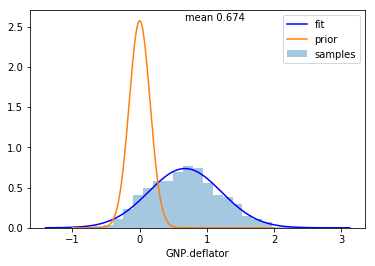

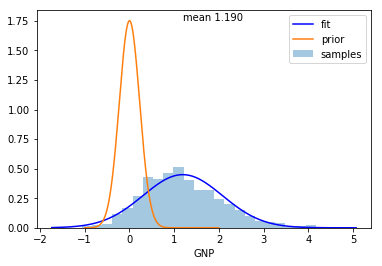

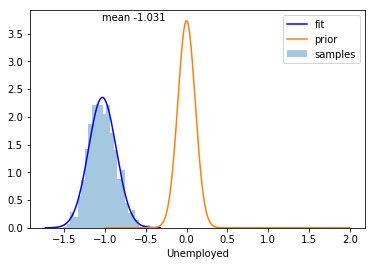

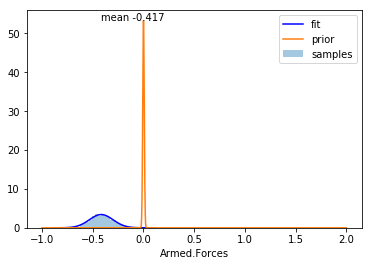

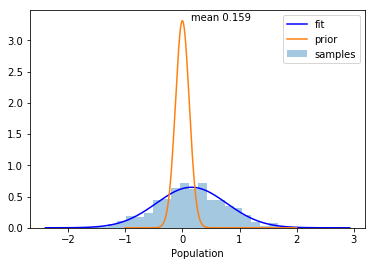

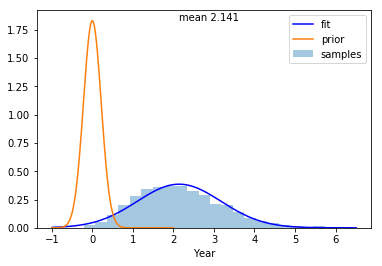

In [25]:
for i in range(samples.shape[1]):
    sns.distplot(samples[:,i], fit=norm, axlabel=D.columns[i], kde=False, hist_kws={"label":"samples"}, fit_kws={"label":"fit","color":"b"})
    xx = np.linspace(-1,2, 2000)
    n = norm.pdf(xx, loc=0, scale=sigma_sqr_0 * 1/tau_0[i])
    plt.plot(xx, n, label='prior')
    plt.text(np.mean(samples[:,i]), n.max(), 'mean %.3f' % np.mean(samples[:,i]))
    plt.legend()
    plt.show()